### 1. 히스토그램 역투영 (Histogram backprojection)
    - 기준 영상의 히스토그램 정보를 이용하여 입력 영상에서 찾고자 하는 물체를 검출하는 방법
    - 컬러 분포로만 검출하는 방법
    - 히스토그램을 매핑 함수로 사용하여, 화소 값을 신뢰도 값으로 변환 (화소값 → 모델 히스토그램 → 신뢰도 값)
    - 영상의 각 픽셀이 주어진 히스토그램 모델에 얼마나 일치하는지 검사하는 것

#### ex) 피부색 영역 검출하기
- RGB 색상 공간 ⇒ HSL 색상 공간으로 변환
    - H(Hue) : 색상
    - S(Saturation) : 채도
    - L(Lightness) : 밝기

- 밝기(L)은 조명에 따라 쉽게 변하고 피부와 비슷한 밝기를 갖는 다른 영역이 여러군데 존재할 가능성이 높음
- 따라서 밝기(L)은 무시하고 색상(H)과 채도(S)를 사용함

### 2. 수행 과정

<img src="img/H-S histogram.jpg" alt='histogram' width="60%" height="60%">

- 기준 영상 m의 모델 얼굴에서 모델 히스토그램 $h_m$을 구하고 정규화
- 새로운 입력 영상 i가 주어지면 $h_m$을 이용해서 피부색 영역 검출

<img src="img/function.PNG" alt='function' width="50%" height="50%">

$\hat{h_m}$ : 기준 영상의 정규화된 히스토그램<br>
$\hat{h_i}$ : 타겟의 정규화된 히스토그램

결과<br>
<img src="img/backprojection result.jpg" alt='function' width="60%" height="60%">

### 3. 장단점
- 장점
    - 물체의 이동이나 회전이 발생하더라도 히스토그램은 불변하므로 성능이 유지
    - 배경의 색 분포가 균일하면서 물체의 색 분포와 겹치지 않는 경우에 유용함

- 한계
    - 비슷한 색 분포를 갖는 다른 물체를 구별 못함
    - 검출 대상이 여러 색 분포를 갖는 경우 여러 개의 모델을 사용해야 하므로 오류 가능성이 높아짐
    - 피부색 검출의 경우 인종에 따라 결과가 달라짐
    - 따라서 컴퓨터 비전분야의 물체 검출 문제에서는 모양 특징을 주로 사용하며, 상황에 따라 색 정보를 보조적으로 사용함

### 코드 실습
### 1. 기준 영상 정보 확인

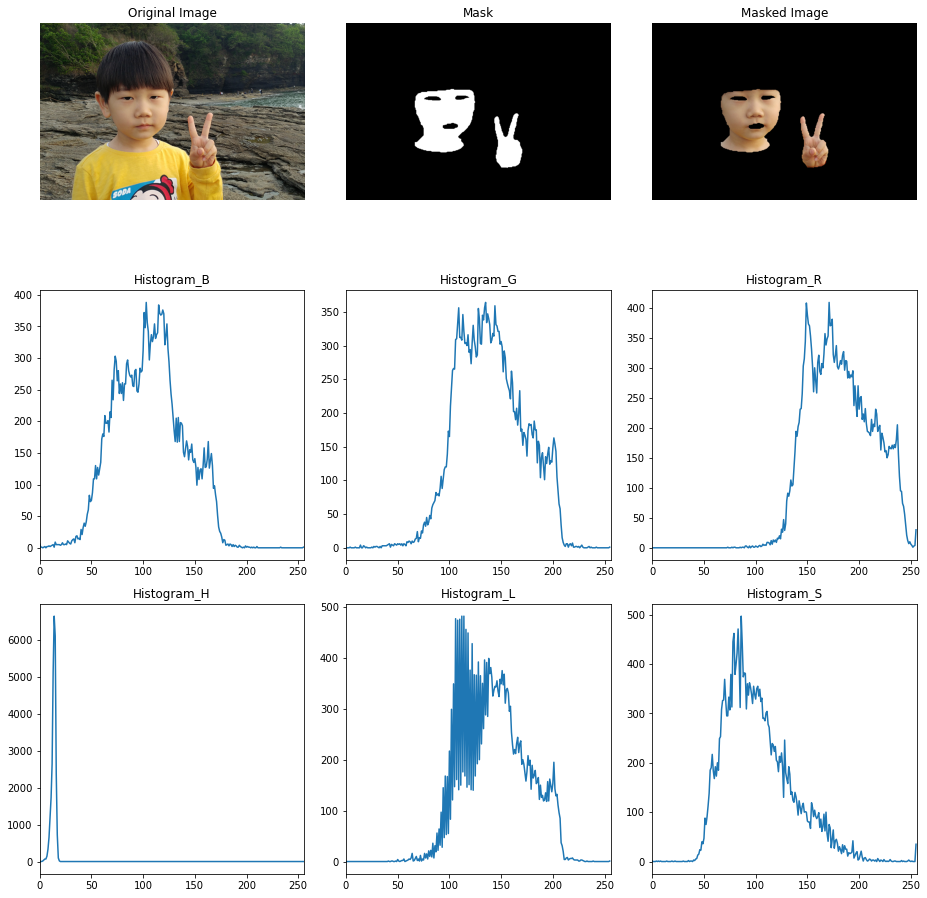

In [32]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

# 기준 영상 읽어오기
img_m = cv2.imread('model.png')
mask = cv2.imread('mask.bmp', cv2.IMREAD_GRAYSCALE)
masked_img = cv2.bitwise_and(img_m, img_m, mask=mask)

# 기준 영상의 rgb 히스토그램 계산
hist_b = cv2.calcHist([img_m], [0], mask, [256], [0, 256])
hist_g = cv2.calcHist([img_m], [1], mask, [256], [0, 256])
hist_r = cv2.calcHist([img_m], [2], mask, [256], [0, 256])

# rgb → hsl 변환
his_m = cv2.cvtColor(img_m, cv2.COLOR_BGR2HLS)

# 기준 영상의 hsl 히스토그램 계산
hist_h = cv2.calcHist([his_m], [0], mask, [256], [0, 256])
hist_l = cv2.calcHist([his_m], [1], mask, [256], [0, 256])
hist_s = cv2.calcHist([his_m], [2], mask, [256], [0, 256])


plt.figure(figsize=(13, 13))

plt.subplot(331), plt.imshow(img_m[...,::-1]), plt.title('Original Image'), plt.axis('off')
plt.subplot(332), plt.imshow(mask, 'gray'), plt.title('Mask'), plt.axis('off')
plt.subplot(333), plt.imshow(masked_img[...,::-1]), plt.title('Masked Image'), plt.axis('off')

plt.subplot(334), plt.plot(hist_b), plt.title('Histogram_B'), plt.xlim([0,256])
plt.subplot(335), plt.plot(hist_g), plt.title('Histogram_G'), plt.xlim([0,256])
plt.subplot(336), plt.plot(hist_r), plt.title('Histogram_R'), plt.xlim([0,256])

plt.subplot(337), plt.plot(hist_h), plt.title('Histogram_H'), plt.xlim([0,256])
plt.subplot(338), plt.plot(hist_l), plt.title('Histogram_L'), plt.xlim([0,256])
plt.subplot(339), plt.plot(hist_s), plt.title('Histogram_S'), plt.xlim([0,256])

plt.tight_layout()
plt.show()


### 2. 히스토그램 역투영

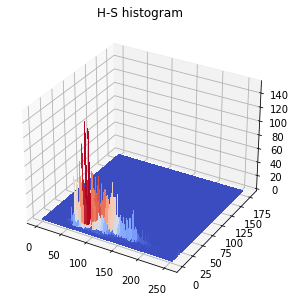

In [30]:
# 기준 영상 피부색 영역 2차원 히스토그램 시각화
from mpl_toolkits.mplot3d import Axes3D
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


img_m = cv2.imread('model.png')
mask = cv2.imread('mask.bmp', cv2.IMREAD_GRAYSCALE)

his_m = cv2.cvtColor(img_m, cv2.COLOR_BGR2HLS)
hist_m = cv2.calcHist([his_m], [0, 2], mask, [181, 256], [0, 181, 0, 256])

fig = plt.figure()
ax = fig.gca(projection='3d')

X = np.arange(256)
Y = np.arange(181)
X,Y = np.meshgrid(X,Y)

surf = ax.plot_surface(X,Y,hist_m, cmap='coolwarm', linewidth=0, antialiased=False)

fig.tight_layout()
plt.title('H-S histogram')
plt.show()

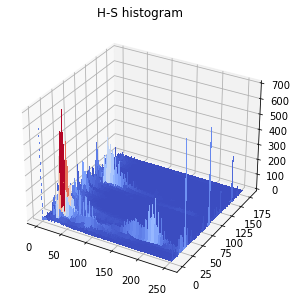

In [31]:
# 입력 영상 피부색 영역 2차원 히스토그램 시각화
img_i = cv2.imread('test.png')
his_i = cv2.cvtColor(img_i, cv2.COLOR_BGR2HLS)

hist_i = cv2.calcHist([his_i], [0, 2], None, [181, 256], [0, 181, 0, 256])
hist_i = np.minimum(hist_i, 700)

fig = plt.figure()
ax = fig.gca(projection='3d')

X = np.arange(256)
Y = np.arange(181)
X,Y = np.meshgrid(X,Y)

surf = ax.plot_surface(X,Y,hist_i, cmap='coolwarm', linewidth=0, antialiased=False)

fig.tight_layout()
plt.title('H-S histogram')
plt.show()